In [2]:
#imports 
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import line


# Reading map

(400, 680, 3)


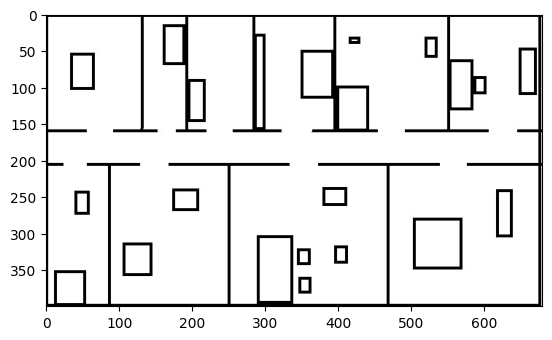

In [3]:
#read the map
map=cv2.imread('./Map.jpg')
#convert to grayscale
map=cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
#make map black and white
print(map.shape)
# print(map)
# map[100][100:104]=(255,0,0)
# map[101][100:104]=(255,0,0)
# map[102][100:104]=(255,0,0)
# map[103][100:104]=(255,0,0)
#show the map
plt.imshow(map)


# Problem 1

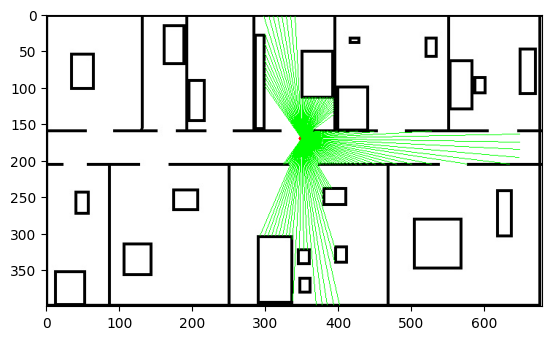

In [61]:
distances=[]
def draw_rays(x,y,theta,max_measurement=1200,map=map,opening_angle=250,step=2):
    max_measurement = max_measurement//4
    # map[y][x:x+4]=(255,0,0)
    # map[y+1][x:x+4]=(255,0,0)
    # map[y+2][x:x+4]=(255,0,0)
    # map[y+3][x:x+4]=(255,0,0)
    cv2.circle(map,(x,y),4,(255,0,0),thickness=-4)
    for i in range(-opening_angle//2,(opening_angle//2)+1,step):
        end_x = int(x + max_measurement * np.cos(np.radians(theta + i)))
        end_y = int(y + max_measurement * np.sin(np.radians(theta + i)))
        #draw line
        pixelx,pixely=line(x,y,end_x,end_y)
        # print(pixelx)
        # print(pixely)
        for index_x,index_y in zip(pixelx,pixely):
            if index_x>=0 and index_x<map.shape[1] and index_y>=0 and index_y<map.shape[0]:
                # print((map[index_x][index_y]))
                if np.array_equal(map[index_y, index_x], [0, 0, 0]):
                    end_x=index_x
                    end_y=index_y
                    break
        
        cv2.line(map,(x,y),(end_x,end_y),(0,255,0),1)
        distances.append(np.sqrt((end_x-x)**2+(end_y-y)**2))   
    return map
map=cv2.imread('./Map.jpg')
map = draw_rays(350, 170, 0, map=map)
plt.imshow(map)

In [185]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


# Problem 2

1.0
0.0009990009990009992


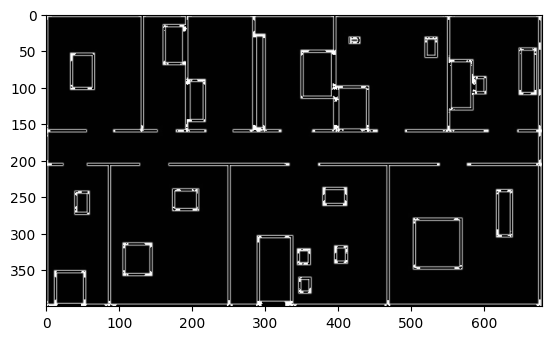

In [223]:
#preparing the map to be like the likelihood field
# converting white to black and vice versa
map=cv2.imread('./Map.jpg')
map=cv2.cvtColor(map, cv2.COLOR_BGR2GRAY)
map=255-map
#want to convert it to grayscale
map=cv2.GaussianBlur(map,(3,3),0)
map+=1
map=map/255
map+=0.001
map=map/np.max(map)
#convert to grayscale
plt.imshow(map,cmap='gray')
print(np.max(map))
print(np.min(map))

In [ ]:
def find_robot_pose(map, distances):
    position_x = 0
    position_y = 0
    orientation = 0
    max_theta_probability = 0
    max_probability = 0
    max_probablity_for_theta = []
    theta_probablity = 1
    max_prob_map =map # Map for storing max probabilities

    for y in range(0, map.shape[0], 5):
        for x in range(0, map.shape[1], 5):
            all_theta_probablities = []
            for theta in range(0, 360, 10):
                probablities = []
                # vectorize the code
                end_x = ((x + np.array(distances) * np.cos(np.radians(theta)))).astype(
                    int
                )
                end_y = ((y + np.array(distances) * np.sin(np.radians(theta)))).astype(
                    int
                )
                valid_indices = (
                    (end_x >= 0)
                    & (end_x < map.shape[1])
                    & (end_y >= 0)
                    & (end_y < map.shape[0]) 
                )
                end_x_valid = end_x[valid_indices]
                end_y_valid = end_y[valid_indices]
                
                # Exclude points on obstacles (value 1)
                non_obstacle_indices = map[end_y_valid, end_x_valid] != 1
                end_x_valid = end_x_valid[non_obstacle_indices]
                end_y_valid = end_y_valid[non_obstacle_indices]
                # i want discard the points that are obstacles which has value of map[end_y,end_x]=1
                # Get probabilities for valid points
                # print("valid_indices")
                # print(len(valid_indices))
                if not np.any(valid_indices):
                    for i in range(126-len(valid_indices)):
                        
                        probablities.append(1e-5)
                else:

                    # Get probabilities for valid points
                    probablities_local = max_prob_map[
                        end_y_valid, end_x_valid
                    ]
                    probablities.append(probablities_local)
                    # print(np.max(  probablities))
                    # break
                # print(len(probablities))
                # multiply all probablities with each  other
                theta_probablity = np.prod(probablities)
                # print(theta_probablity)
                # break
                all_theta_probablities.append(theta_probablity)
            # find the max probablity
            # Store max theta probability
            max_theta_probability = max(all_theta_probablities)
            # print(max_theta_probability)
            # break
            max_prob_map[y, x] = max_theta_probability

            # Update global max probability and orientation
            if max_theta_probability > max_probability:
                max_probability = max_theta_probability
                position_x, position_y = x, y
                orientation = all_theta_probablities.index(max_theta_probability) * 2
                print(position_x, position_y, theta,max_probability)
            # find the position
    # position_y,position_x=np.unravel_index(np.argmax(map),map.shape)

    # map[y][x]=max_probablity
    # position_x=x
    # position_y=y
    # orientation=all_theta_probablities.index(max_probablity)*2
    print(position_x, position_y, orientation)

    position_p = np.zeros((map.shape[0], map.shape[1]))
    position_p[position_y, position_x] = 255
    print(f"Position: ({position_x}, {position_y}), Orientation: {orientation} with max probability: {max_probability}")

    return map, position_p

new_map, position = find_robot_pose(map, distances)
plt.imshow(map, cmap="gray")
plt.imshow(position, cmap="gray")
# print(new_map)

In [240]:
def find_robot_pose(map, distances):
    position_x = 0
    position_y = 0
    orientation = 0
    max_theta_probability = 0
    max_probability = 0
    max_probablity_for_theta = []
    theta_probablity = 1
    max_prob_map =map # Map for storing max probabilities

    for y in range(0, map.shape[0], 5):
        for x in range(0, map.shape[1], 5):
            all_theta_probablities = []
            for theta in range(0, 360, 10):
                probablities = []
                # vectorize the code
                end_x = ((x + np.array(distances) * np.cos(np.radians(theta)))).astype(
                    int
                )
                end_y = ((y + np.array(distances) * np.sin(np.radians(theta)))).astype(
                    int
                )
                valid_indices = (
                    (end_x >= 0)
                    & (end_x < map.shape[1])
                    & (end_y >= 0)
                    & (end_y < map.shape[0]) 
                )
                end_x_valid = end_x[valid_indices]
                end_y_valid = end_y[valid_indices]
                
                # # Exclude points on obstacles (value 1)
                # non_obstacle_indices = map[end_y_valid, end_x_valid] != 1
                # end_x_valid = end_x_valid[non_obstacle_indices]
                # end_y_valid = end_y_valid[non_obstacle_indices]
                # i want discard the points that are obstacles which has value of map[end_y,end_x]=1
                # Get probabilities for valid points
                # print("valid_indices")
                # print(len(valid_indices))
                if not np.any(valid_indices):
                    for i in range(126-len(valid_indices)):
                        
                        probablities.append(1e-5)
                else:

                    # Get probabilities for valid points
                    probablities_local = max_prob_map[
                        end_y[valid_indices], end_x[valid_indices]
                    ]
                    probablities.append(probablities_local)
                    # print(np.max(  probablities))
                    # break
                # print(len(probablities))
                # multiply all probablities with each  other
                theta_probablity = np.prod(probablities)
                # print(theta_probablity)
                # break
                all_theta_probablities.append(theta_probablity)
            # find the max probablity
            # Store max theta probability
            max_theta_probability = max(all_theta_probablities)
            # print(max_theta_probability)
            # break
            max_prob_map[y, x] = max_theta_probability

            # Update global max probability and orientation
            if max_theta_probability >= max_probability:
                max_probability = max_theta_probability
                position_x, position_y = x, y
                orientation = all_theta_probablities.index(max_theta_probability) * 2
                print(position_x, position_y, theta,max_probability)
            # find the position
    # position_y,position_x=np.unravel_index(np.argmax(map),map.shape)

    # map[y][x]=max_probablity
    # position_x=x
    # position_y=y
    # orientation=all_theta_probablities.index(max_probablity)*2
    print(position_x, position_y, orientation)

    position_p = np.zeros((map.shape[0], map.shape[1]))
    position_p[position_y, position_x] = 255
    print(f"Position: ({position_x}, {position_y}), Orientation: {orientation} with max probability: {max_probability}")

    return map, position_p

new_map, position = find_robot_pose(map, distances)
plt.imshow(map, cmap="gray")
plt.imshow(position, cmap="gray")
# print(new_map)

0 0 350 1.0


KeyboardInterrupt: 

255.0
0 0


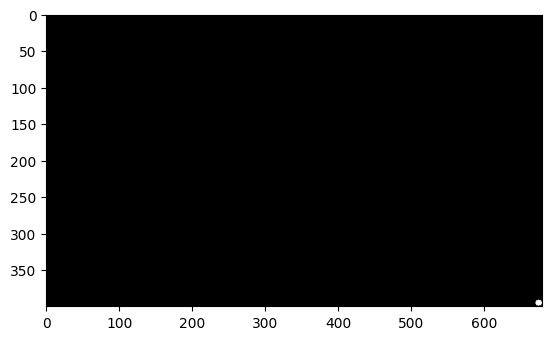

In [227]:
# print(map.shape)
#max of the map
# Dilate image
circle_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9 ,9))
# Dilate the image using the circular structuring element
dilated_image = cv2.dilate(position, circle_kernel)
print(np.max(position))
y,x=np.unravel_index(np.argmax(map),position.shape)
print(y,x)
plt.imshow(dilated_image,cmap='gray')